/tmp/ipykernel_3168/756827555.py:36: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html_content)
/tmp/ipykernel_3168/756827555.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Streams", y="Song", palette="Greens")


DataFrame Columns before renaming: Index(['Rank', 'Song', 'Artist(s)', 'Streams (billions)', 'Release date',
       'Ref.'],
      dtype='object')
Successfully inserted 100 rows into table most_streamed.


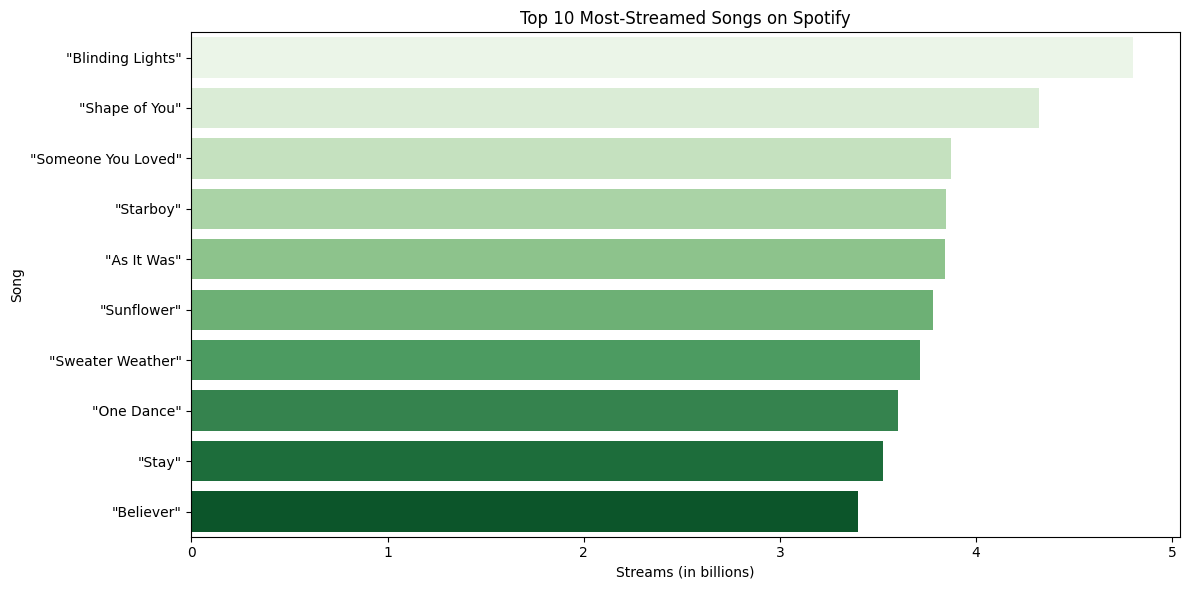

In [9]:
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_html(url):
    """
    Fetches the HTML content from a given URL.

    Args:
        url (str): The URL to retrieve.

    Returns:
        str: The HTML content, or None on error.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

def extract_tables(html_content):
    """
    Extracts all tables from the HTML content using pandas.

    Args:
        html_content (str): The HTML content to parse.

    Returns:
        list: A list of pandas DataFrames, or an empty list on error.
    """
    try:
        tables = pd.read_html(html_content)
        return tables
    except ValueError as e:
        print(f"Error parsing HTML: {e}")
        return []

def process_dataframe(df):
    """
    Processes the extracted DataFrame to clean and format the data.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame, or None on error.
    """
    try:
        df = df.copy()
        # Print the columns to debug
        print("DataFrame Columns before renaming:", df.columns)

        # Check if the expected columns exist
        expected_columns = ["Rank", "Song", "Artist(s)", "Streams (billions)", "Release date", "Ref."]
        for col in expected_columns:
            if col not in df.columns:
                print(f"Error: Column '{col}' not found in DataFrame.  Expected one of: {expected_columns}")
                return None  # Return None if a required column is missing

        new_columns = {"Rank": "Rank", "Song": "Song", "Artist(s)": "Artist",  # Changed "Artist" to "Artist(s)"
                       "Streams (billions)": "Streams", "Release date": "Release_Date",  # Changed "Date released" to "Release date"
                       "Ref.": "Reference"}  # Changed "Reference" to "Ref."
        df = df.rename(columns=new_columns)

        df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True).str.strip()
        df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True).str.strip()
        df = df[df["Streams"].astype(str).str.match(r"^\d+(\.\d+)?$")].copy()
        df["Streams"] = pd.to_numeric(df["Streams"], errors='coerce')
        df["Release_Date"] = pd.to_datetime(df["Release_Date"], errors="coerce")
        df = df.dropna(subset=['Streams', 'Release_Date'])
        return df
    except KeyError as e:
        print(f"KeyError in DataFrame processing: {e}. Check column names.")
        return None
    except Exception as e:
        print(f"Error processing DataFrame: {e}")
        return None

def store_data(df, db_name="spotify_top_songs.db", table_name="most_streamed"):
    """
    Stores the processed data in a SQLite database.

    Args:
        df (pd.DataFrame): The DataFrame to store.
        db_name (str): The name of the SQLite database file.
        table_name (str): The name of the table to create/replace.
    """
    try:
        conn = sqlite3.connect(db_name)
        df.to_sql(table_name, conn, if_exists="replace", index=False)
        cursor = conn.cursor()
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        row_count = cursor.fetchone()[0]
        print(f"Successfully inserted {row_count} rows into table {table_name}.")
        conn.commit()
        conn.close()
    except sqlite3.Error as e:
        print(f"Error storing data in SQLite: {e}")

def visualize_data(df):
    """
    Visualizes the top 10 most-streamed songs using a bar plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
    """
    try:
        top10 = df.nlargest(10, "Streams")
        plt.figure(figsize=(12, 6))
        sns.barplot(data=top10, x="Streams", y="Song", palette="Greens")
        plt.title("Top 10 Most-Streamed Songs on Spotify")
        plt.xlabel("Streams (in billions)")
        plt.ylabel("Song")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during data visualization: {e}")

def main(url="https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"):
    """
    Main function to orchestrate the web scraping, data processing, storage, and visualization.

    Args:
        url (str): The URL to scrape.
    """
    html_content = fetch_html(url)
    if html_content:
        tables = extract_tables(html_content)
        if tables:
            if len(tables) > 0:
                df = tables[0]
                processed_df = process_dataframe(df)
                if processed_df is not None:
                    store_data(processed_df)
                    visualize_data(processed_df)
                else:
                    print("Failed to process the DataFrame.")
            else:
                print("No tables found in the HTML.")
        else:
            print("Failed to extract tables from the HTML content.")
    else:
        print("Failed to fetch HTML content.")

if __name__ == "__main__":
    main()
